In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torchvision.transforms  import ToTensor
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import time
import matplotlib.pyplot as plt
from skimage import io
import sys


In [2]:

# Data Loader
import sys
sys.path.insert(0, '/Users/pauli/Documents/Studium/Master/3. Semester Auslandssemester DTU/Deep Learning/Final Project/Otovo/')
#from autotetris.dataloader import RoofDataSet
from dataloader import RoofDataSet
from dataloader import Transforms
from dataloader import show_centroids


In [3]:
path = os.getcwd()
path += '/small_sample_out/metadata_sample.hdf'
input_path = path
print(path)
df = pd.read_hdf(path, '/d')
# centroid=df.iloc[:,6].values
# test = df.building_id.str.split('-b15',n = 1, expand = True)[0].tolist()
centroid = np.array(df.panel_centroids.to_list())

/Users/pauli/Documents/Studium/Master/3. Semester Auslandssemester DTU/Deep Learning/Final Project/Otovo/autotetris/small_sample_out/metadata_sample.hdf


/var/folders/qr/qkrmmr2128n2qj9wbb_bhwgc0000gn/T/ipykernel_2633/1492467869.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  centroid = np.array(df.panel_centroids.to_list())


In [4]:
dataset = RoofDataSet(path, transform=Transforms(new_size=(256,256)))

In [5]:
# image = cv2.imread('C:/Users/guzma/OneDrive/Documents/TEC/DTU/02456/Project/Github_Project/autotetris/small_sample_out/2d5c5e72-bf4a-4e02-8768-5dd987583398-b15-otovowms.jpeg')
image = cv2.imread(dataset.image_paths[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [6]:
len(dataset)

100

In [37]:
# split the dataset into training, validation and test sets
# Create testset
len_test_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_test_set

train_dataset , test_dataset  = torch.utils.data.random_split(dataset, [len_train_set, len_test_set])


len_valid_set = int(0.1*len(train_dataset))
len_train_set = len(train_dataset) - len_valid_set

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [len_train_set, len_valid_set])

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))


# shuffle and batch the datasets
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

The length of Train set is 81
The length of Valid set is 9
The length of Test set is 10


ValueError: too many values to unpack (expected 2)

In [11]:
# Test sizes of tensors for adjusting Resnet input and output layer
image, centroids = next(iter(train_loader))

print("The size of image tensor set is {}".format(image.shape))
print("The size of centroids tensor set is {}".format(centroids.shape))

The size of image tensor set is torch.Size([6, 3, 256, 256])
The size of centroids tensor set is torch.Size([6, 106, 2])


In [12]:
# Test sizes of tensors for adjusting Resnet validation
image, centroids = next(iter(valid_loader))

print("The size of image tensor set is {}".format(image.shape))
print("The size of centroids tensor set is {}".format(centroids.shape))


The size of image tensor set is torch.Size([6, 3, 256, 256])
The size of centroids tensor set is torch.Size([6, 106, 2])


In [13]:
class Network(nn.Module):
    def __init__(self,num_classes=212):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [16]:
# Helper function
def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [39]:
def model_resnet18(network, criterion, optimizer, num_epochs, train_loader, valid_loader):
    start_time = time.time()

    for epoch in range(1,num_epochs+1):
        loss_train = 0
        loss_valid = 0
        running_loss = 0

        network.train()

        for step in range(1,len(train_loader)+1):

            images, centroids = next(iter(train_loader))

            images = images.to(device)
            centroids = centroids.view(centroids.size(0),-1).to(device)

            predictions = network(images)

            # clear all the gradients before calculating them
            optimizer.zero_grad()

            # find the loss for the current step
            loss_train_step = criterion(predictions, centroids)

            # calculate the gradients
            loss_train_step.backward()

            # update the parameters
            optimizer.step()

            loss_train += loss_train_step.item()
            running_loss = loss_train/step

            print_overwrite(step, len(train_loader), running_loss, 'train')

        network.eval()
        with torch.no_grad():

            for step in range(1,len(valid_loader)+1):

                images, centroids = next(iter(valid_loader))

                images = images.to(device)
                centroids = centroids.view(centroids.size(0),-1).to(device)

                predictions = network(images)

                # find the loss for the current step
                loss_valid_step = criterion(predictions, centroids)

                loss_valid += loss_valid_step.item()
                running_loss = loss_valid/step

                print_overwrite(step, len(valid_loader), running_loss, 'valid')

        loss_train /= len(train_loader)
        loss_valid /= len(valid_loader)

        print('\n--------------------------------------------------')
        print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
        print('--------------------------------------------------')

    print('Training Complete')
    print("Total Elapsed Time : {} s".format(time.time()-start_time))
    return network


In [40]:
network = Network()
network.to(device)
# print(network)

# Adjust network parameter
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 10

# Train model
model = model_resnet18(network, criterion, optimizer, num_epochs, train_loader, valid_loader)


Valid Steps: 1/1  Loss: 4577.1870 
--------------------------------------------------
Epoch: 1  Train Loss: 5519.1893  Valid Loss: 4577.1870
--------------------------------------------------
Valid Steps: 1/1  Loss: 4537.9639 
--------------------------------------------------
Epoch: 2  Train Loss: 5701.2542  Valid Loss: 4537.9639
--------------------------------------------------
Valid Steps: 1/1  Loss: 4485.6387 
--------------------------------------------------
Epoch: 3  Train Loss: 4725.1009  Valid Loss: 4485.6387
--------------------------------------------------
Valid Steps: 1/1  Loss: 4445.9194 
--------------------------------------------------
Epoch: 4  Train Loss: 5238.3869  Valid Loss: 4445.9194
--------------------------------------------------
Valid Steps: 1/1  Loss: 4464.9854 
--------------------------------------------------
Epoch: 5  Train Loss: 5293.5299  Valid Loss: 4464.9854
--------------------------------------------------
Valid Steps: 1/1  Loss: 4472.6548 
-----

In [55]:
image, centroids = next(iter(test_loader))
print(image.squeeze().shape)

prediction = model(image)
prediction = prediction.view(-1, 106, 2)


torch.Size([3, 256, 256])


In [ ]:
prediction

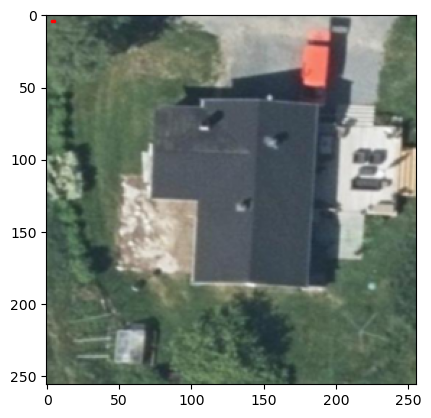

In [42]:
show_centroids(image.squeeze(), prediction, tensor=True)

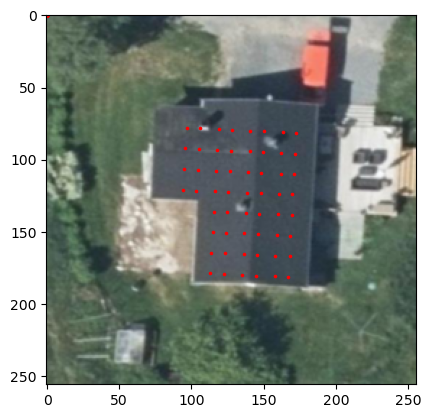

In [56]:
image = image.squeeze()
image = image.permute(1, 2, 0)
centroids = centroids.numpy()
centroids = centroids[0]
show_centroids(image.squeeze(), centroids[0], tensor=False)

In [53]:
centroids[0]

array([[ 77.824,  96.768],
       [ 78.336, 105.984],
       [ 92.16 ,  95.744],
       [ 92.672, 104.96 ],
       [106.496,  94.72 ],
       [107.008, 104.448],
       [120.832,  94.208],
       [121.344, 103.424],
       [ 78.848, 118.784],
       [ 79.36 , 128.   ],
       [ 93.184, 117.76 ],
       [ 93.696, 127.488],
       [107.52 , 117.248],
       [108.032, 126.464],
       [121.856, 116.224],
       [122.368, 125.44 ],
       [136.192, 115.712],
       [136.192, 124.928],
       [150.016, 114.688],
       [150.528, 123.904],
       [164.352, 113.664],
       [164.864, 123.392],
       [178.688, 113.152],
       [179.2  , 122.368],
       [ 79.872, 140.8  ],
       [ 80.384, 150.528],
       [ 94.208, 140.288],
       [ 94.72 , 149.504],
       [108.544, 139.264],
       [109.056, 148.48 ],
       [122.88 , 138.752],
       [122.88 , 147.968],
       [136.704, 137.728],
       [137.216, 146.944],
       [151.04 , 136.704],
       [151.552, 146.432],
       [165.376, 136.192],
 

In [45]:
centroids[0,:]

tensor([[ 77.8240,  96.7680],
        [ 78.3360, 105.9840],
        [ 92.1600,  95.7440],
        [ 92.6720, 104.9600],
        [106.4960,  94.7200],
        [107.0080, 104.4480],
        [120.8320,  94.2080],
        [121.3440, 103.4240],
        [ 78.8480, 118.7840],
        [ 79.3600, 128.0000],
        [ 93.1840, 117.7600],
        [ 93.6960, 127.4880],
        [107.5200, 117.2480],
        [108.0320, 126.4640],
        [121.8560, 116.2240],
        [122.3680, 125.4400],
        [136.1920, 115.7120],
        [136.1920, 124.9280],
        [150.0160, 114.6880],
        [150.5280, 123.9040],
        [164.3520, 113.6640],
        [164.8640, 123.3920],
        [178.6880, 113.1520],
        [179.2000, 122.3680],
        [ 79.8720, 140.8000],
        [ 80.3840, 150.5280],
        [ 94.2080, 140.2880],
        [ 94.7200, 149.5040],
        [108.5440, 139.2640],
        [109.0560, 148.4800],
        [122.8800, 138.7520],
        [122.8800, 147.9680],
        [136.7040, 137.7280],
        [1